This is for testing how the accuracy of the data changes with framenumber for 1 or 0 labels only

In [33]:
import numpy as np
import torch
import torch.nn as nn
from babel.dates import time_
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
import time
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter

In [34]:
#loaded network
class SiameseNetwork(nn.Module):
	def __init__(self):
		super(SiameseNetwork,self).__init__()
		self.cnn1 = nn.Sequential(nn.Conv2d(1, 96,
											kernel_size=11, stride = 1),
								  nn.ReLU(inplace = True),
								  nn.LocalResponseNorm(5, alpha = 0.0001, beta = 0.75, k=2),
								  nn.MaxPool2d(3, stride=2),
								  nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
								  nn.ReLU(inplace=True),nn.LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2),
								  nn.MaxPool2d(3, stride=2), nn.Dropout2d(p=0.3),
								  nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
								  nn.ReLU(inplace=True),
								  nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),
								  nn.ReLU(inplace=True),
								  nn.MaxPool2d(3, stride = 2), nn.Dropout2d(p=0.3), )

		self.fc1 = nn.Sequential(nn.Linear(43264,1024), nn.ReLU(inplace=True),
								 nn.Dropout(p=0.5),
								 nn.Linear(1024, 128),
								 nn.ReLU(inplace=True),
								 nn.Linear(128, 1))
	def forward(self, img1, img2):
		x1 = self.cnn1(img1)
		x2 = self.cnn1(img2)
		x1 = x1.view(x1.size(0), -1)
		x2 = x2.view(x2.size(0), -1)
		distance = torch.abs(x1 - x2)
		score = self.fc1(distance)
		output = 1-torch.sigmoid(score)
		return output
CNN_directory = r"A:\3rd_Year_Project\Project_code\BestRun_lr0.01_bs64_epoch3000_op_class 'torch.optim.sgd.SGD'__acc63.1loss0.282.pth"
checkpoint = torch.load(CNN_directory)
model = SiameseNetwork()
model.load_state_dict(checkpoint["model_state_dict"])
model.cuda()
model.eval()

C:\Users\user\AppData\Local\Temp\ipykernel_21236\2419357212.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(CNN_directory)


SiameseNetwork(
  (cnn1): Sequential(
    (0): Conv2d(1, 96, kernel_size=(11, 11), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): LocalResponseNorm(5, alpha=0.001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Dropout2d(p=0.3, inplace=False)
    (9): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU(inplace=True)
    (11): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Dropout2d(p=0.3, inplace=False)
  )
  (fc1): Sequential(
    (0): Linear(in_features=43264, out_features=1024, bias=True)
    (1): ReL

In [35]:
class SiameseNetworkDataset(torch.utils.data.Dataset):
	def __init__(self, img1_dir, img2_dir, transform = None):
		self.img1_data = np.load(img1_dir)
		self.img1_images = self.img1_data['images']
		self.img1_labels = self.img1_data['labels']

		self.img2_data = np.load(img2_dir)
		self.img2_images = self.img2_data['images']
		self.img2_labels = self.img2_data['labels']
		self.transform = transform

	def __getitem__(self, index):
		random_index = np.random.choice(len(self.img1_images))
		random_num = random_index
		img1 = Image.fromarray(self.img1_images[random_num]).convert("L")
		img2 = self.img2_images[index]
		img2 = Image.fromarray(img2).convert("L")

		#if self.img1_labels[random_num] == self.img2_labels[index]:
		#	label = 0
		#else:
		#	label = 1
		label = abs(self.img1_labels[random_num] - self.img2_labels[index])

		if self.transform:
			img1 = self.transform(img1)
			img2 = self.transform(img2)
		label = torch.tensor(float(label), dtype=torch.float32).squeeze(0)
		return img1, img2, label
	def __len__(self):
		return len(self.img2_images)

In [36]:
class ContrastiveLoss(torch.nn.Module):
	def __init__(self):
		super(ContrastiveLoss, self).__init__()
		self.bce = nn.BCELoss()
	def forward(self, output, label):
		loss_contrastive= self.bce(output, label)
		return loss_contrastive

In [37]:
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

In [38]:
img1_directory = "A:/3rd_Year_Project/Project_code/data/Siamese_dataset/img1.npz"
training_directory = "A:/3rd_Year_Project/Project_code/data/cropped_and_variable_labels/15VariableLabel.npz"
training_directory10 = r"A:\3rd_Year_Project\Project_code\data\Siamese_dataset\15.npz"

testing_directory = r"A:\3rd_Year_Project\Project_code\data\Cropped_and_variable_labels\2ndVariableLabel.npz"
testing_directory10 = r"A:\3rd_Year_Project\Project_code\data\Siamese_dataset\2nd.npz"

training_framenumber = np.load(r"A:\3rd_Year_Project\Project_code\data\Cropped_and_variable_labels\framenumber15.npy")
testing_framenumber = np.load(r"A:\3rd_Year_Project\Project_code\data\Cropped_and_variable_labels\framenumber2nd.npy")

In [39]:
print(training_framenumber.shape)
print(testing_framenumber.shape)
print(training_framenumber)
print(testing_framenumber)

(12619,)
(8461,)
[  0   0   0 ... 599 599 599]
[  0   0   0 ... 299 299 299]


In [40]:
y = np.load(training_directory)
print(y.files)
print(y["labels"].shape)

x = np.load(testing_directory)
print(x["labels"].shape)

['images', 'labels']
(12619,)
(8461,)


In [41]:
#choose which directory you want
img1_dir = img1_directory
img2_dir = testing_directory

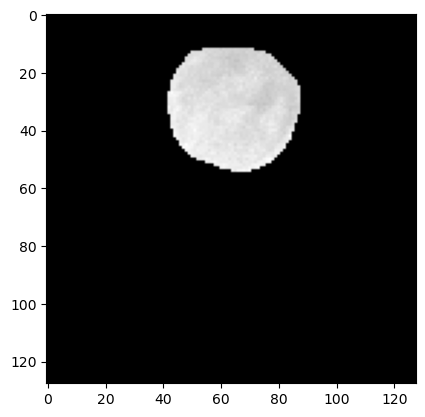

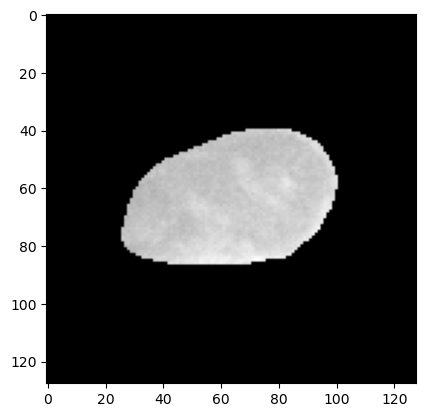

In [42]:
image_data = np.load(img2_dir)
image = image_data['images']
image1 = image[0]
image2 = image[1]
plt.imshow(image1, cmap='gray')
plt.show()
plt.imshow(image2, cmap='gray')
plt.show()
#print(np.max(image1), np.mean(image1))

In [43]:
siamese_dataset = SiameseNetworkDataset(img1_dir=img1_directory,
                                        img2_dir=img2_dir,
                                        transform=transforms.Compose(
                                            [transforms.Resize((128, 128)), transforms.ToTensor()]))
train_dataloader = DataLoader(siamese_dataset,
                              shuffle=False,
                              num_workers=0,
                              batch_size=1,
                              pin_memory=True)

mean = []
start = time.time()
imageNo = 0
iterations = 2
all_lists = {}
criterion = ContrastiveLoss()
lossmean = []
all_loss_lists = {}

for j in range(iterations):
	current_list = []
	asdfjkl = []
	lossky = []
	for img1, img2, label in train_dataloader:
		img1, img2, label = img1.cuda(), img2.cuda(), label.cuda()
		listy = []
		with torch.no_grad():
			output = model(img1, img2)
		label = label.unsqueeze(1)
		loss_contrastive = criterion(output ,label)

		#predicted = int((torch.round(output*10)/10).item()*10)/10 #continuous in steps of 0.01 accuracy
		#labels = int((torch.round(label*10)/10).item()*10)/10 #continuous in steps of 0.01 accuracy
		#accuracy = (1-((predicted-labels)**2)**0.5)*100

		#predicted = torch.round(output).item() #binary, either 0=healthy or 1=dead
		#labels = torch.round(label).item() #binary, either 0=healthy or 1=dead

		difference = ((output - label)**2)**0.5
		accuracy = (1 - difference)*100

		listy.append(accuracy)

		current_list.extend(listy)
		asdfjkl.append(accuracy)
		lossky.append(loss_contrastive.item())
	all_lists[j] = current_list
	all_loss_lists[j] = lossky
	mean.append(np.mean(asdfjkl))
	lossmean.append(np.mean(lossky))

	now = time.time()
	averageTime = (now - start)/(j+1)
	loops_left = iterations - (j+1)
	time_left = loops_left * averageTime
	hours1 = int(time_left % 86400 // 3600)
	minutes1 = int((time_left % 3600) // 60)
	seconds1 = int(time_left % 60)
	print(f"Code {(((j+1)/iterations))*100:.0f}% complete", f"ETA:{hours1}h, {minutes1} min, {seconds1} sec")
	#print(f"Average: {np.mean(asdfjkl):0f}")

print(int(np.mean(mean) * 100) / 100)
print(int(np.mean(lossmean) * 100) / 100)

array = np.array(list(all_lists.values()))
mean_per_image = np.mean(array, axis=0)

array1 = np.array(list(all_loss_lists.values()))
mean_loss = np.mean(array1, axis=0)

print(f"Number of images: {len(mean_per_image)}")
print(f"Average loss: {mean_loss}")

Code 50% complete ETA:0h, 1 min, 42 sec
Code 100% complete ETA:0h, 0 min, 0 sec
68.98
0.57
Number of images: 8461
Average loss: [0.56249638 0.12944868 0.70545328 ... 0.7023899  1.4295283  0.02460674]


In [44]:
#FrameNumber=training_framenumber + 1 #for training data
FrameNumber=testing_framenumber + 1   #for testing data

FrameNumber = FrameNumber.tolist()
#print(len(FrameNumber), len(listy))
new_training_list = [FrameNumber, mean_per_image, mean_loss]
#print(new_training_list)

framey = []
meany = []
std = []
target_list = []

loss_list = []
lossstd = []
losspy = []

for i in range(len(FrameNumber)):
	if FrameNumber[i] not in framey:
		framey.append(FrameNumber[i])
		target_list = []
		loss_list = []
		for j in range(len(FrameNumber)):
			if FrameNumber[i] == FrameNumber[j]:
				target_list.append(mean_per_image[j])
				loss_list.append(mean_loss[j])
		meany.append(np.mean(target_list))
		std.append(np.std(target_list))
		losspy.append(np.mean(loss_list))
		lossstd.append(np.std(loss_list))

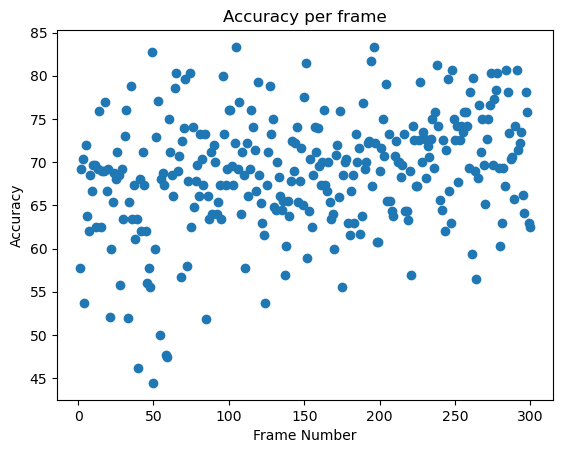

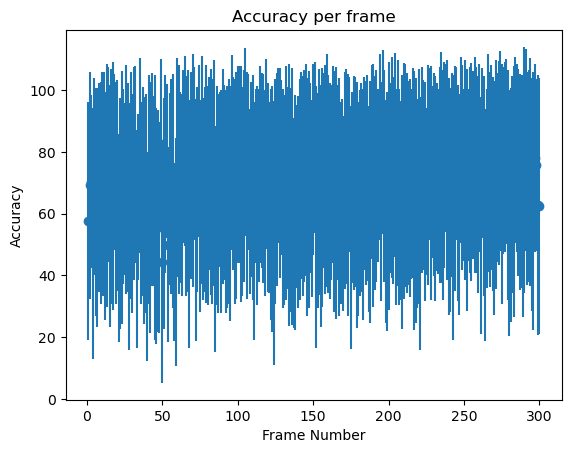

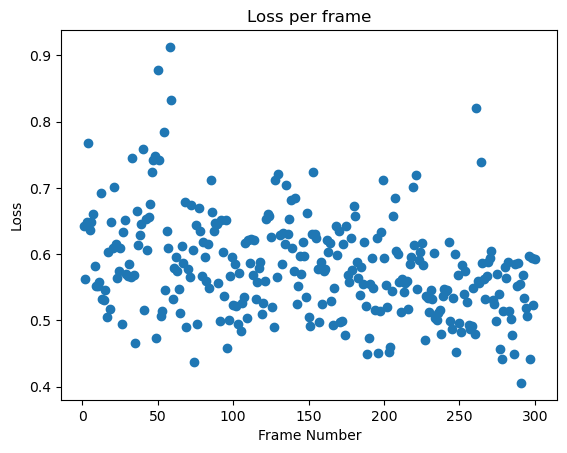

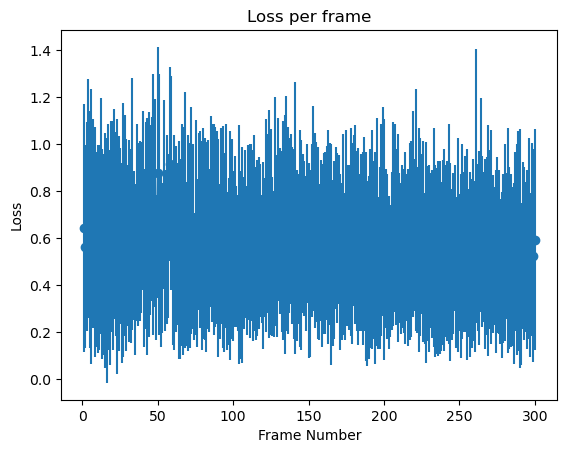

A:\3rd_Year_Project\Project_code\BestRun_lr0.01_bs64_epoch3000_op_class 'torch.optim.sgd.SGD'__acc63.1loss0.282.pth
A:/3rd_Year_Project/Project_code/data/Siamese_dataset/img1.npz
A:\3rd_Year_Project\Project_code\data\Cropped_and_variable_labels\2ndVariableLabel.npz
2


In [51]:
#for plt plots:
filename = fr"A:\3rd_Year_Project\Project_code\data\Accuracy per frame\Acc_per_frame== CNN=_, Data=_-_, Iterations=_.npz"
np.savez_compressed(filename, frameNumber = np.array(framey), Accuracy = np.array(meany), stdAcc = np.array(std), Loss = np.array(losspy), LossStd = np.array(lossstd))

#acc plt graphs
plt.xlabel("Frame Number")
plt.ylabel("Accuracy")
plt.title("Accuracy per frame")
plt.scatter(framey, meany)
plt.show()
plt.errorbar(framey, meany, yerr=std)
plt.xlabel("Frame Number")
plt.ylabel("Accuracy")
plt.title("Accuracy per frame")
plt.scatter(framey, meany)
plt.show()

#loss plt graphs
plt.xlabel("Frame Number")
plt.ylabel("Loss")
plt.title("Loss per frame")
plt.scatter(framey, losspy)
plt.show()
plt.errorbar(framey, losspy, yerr=lossstd)
plt.xlabel("Frame Number")
plt.ylabel("Loss")
plt.title("Loss per frame")
plt.scatter(framey, losspy)
plt.show()

print(CNN_directory)
print(img1_dir)
print(img2_dir)
print(iterations)

In [ ]:
#for tensorboard plots:
writer = SummaryWriter(log_dir = fr"A:\3rd_Year_Project\Project_code\data\Accuracy per frame: CNN={CNN_directory}, Data={img1_dir}-{img2_dir}, Iterations={iterations}")

for i in range(len(framey)):
        writer.add_scalar("Accuracy per frame number", meany[i], framey[i])
        writer.add_scalar("Accuracy per frame number", losspy[i], framey[i])